In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [8]:
start_date = "1984-10-01"
end_date = "2008-12-30"

df_ibovespa = yf.download("^N225", start=start_date, end=end_date)

# Indices de bolsas:
# ^BVSP
# ^IXIC
# ^NYA
# ^DJI
# M.BA
# ^N225
# 000001.SS
# ^HSI
# ^BSESN
# ^FTSE
# ^OMX
# ^GDAXI
# ^FCHI


[*********************100%***********************]  1 of 1 completed


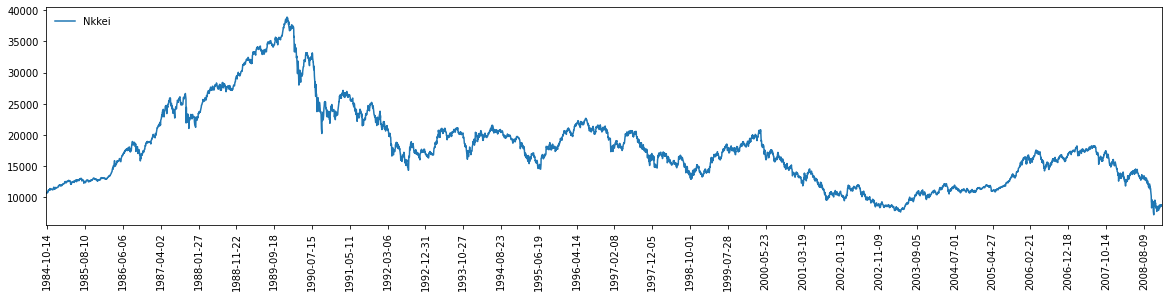

In [9]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label="Nkkei")

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [10]:

X_train = df_ibovespa[:"2008-12-01"]
X_test = df_ibovespa["2008-12-01":]
# X_train = df_ibovespa[:-Ntest]
# X_test = df_ibovespa[-Ntest:]

print(f"""Base original: {df_ibovespa.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")
Ntest = X_test.shape[0]

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
df_ibovespa["rt"] = (np.log(df_ibovespa["Close"]) - np.log(df_ibovespa["Close"].shift(periods=1)))*100
X_train = X_train[["Close", "rt"]][1:]
X_train.head()

Base original: (5976, 6)
X_train: (5957, 6)
X_test: (20, 6)



,Close,rt
Date,,
1984-10-02,10540.049805,-1.073343
1984-10-03,10587.379883,0.448045
1984-10-04,10642.070312,0.515233
1984-10-05,10737.580078,0.893470
1984-10-08,10676.929688,-0.566444


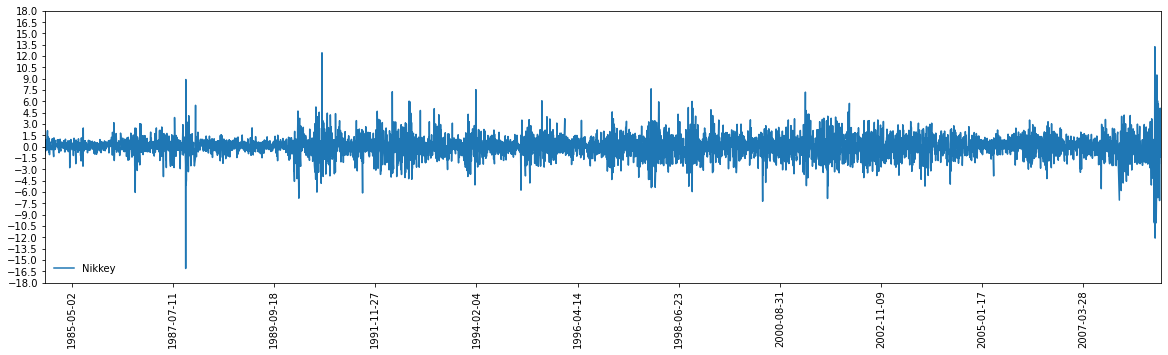

In [11]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

count    5956.000000
mean       -0.003996
std         1.463102
min       -16.135424
25%        -0.691488
50%         0.029844
75%         0.718680
max        13.234592
Name: rt, dtype: float64

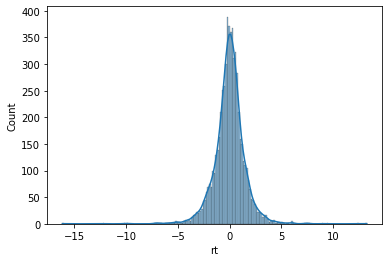

In [12]:
sns.histplot(data=X_train, x="rt", kde=True);
X_train['rt'].describe().T

### ARIMA



In [13]:
X_train

,Close,rt
Date,,
1984-10-02,10540.049805,-1.073343
1984-10-03,10587.379883,0.448045
1984-10-04,10642.070312,0.515233
1984-10-05,10737.580078,0.893470
1984-10-08,10676.929688,-0.566444
...,...,...
2008-11-25,8323.929688,5.090681
2008-11-26,8213.219727,-1.338944
2008-11-27,8373.389648,1.931376


In [14]:
model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=True, suppress_warnings=True, maxinter=10, stepwise=False, seasonal=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21436.656, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=21437.299, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=21412.985, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=21414.882, Time=0.32 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=21416.864, Time=0.38 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=21418.243, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=21437.480, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21428.775, Time=0.65 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=21414.890, Time=0.57 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=21416.904, Time=0.51 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=21418.843, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=21412.799, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=21414.734, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=21416.137, Time=1.63 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=21415.640, Time=2.15

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5956
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -10703.400
Date:                Thu, 24 Jun 2021   AIC                          21412.799
Time:                        00:06:38   BIC                          21432.875
Sample:                             0   HQIC                         21419.774
                               - 5956                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0150      0.007     -2.159      0.031      -0.029      -0.001
ar.L2         -0.0669      0.007     -9.836      0.000      -0.080      -0.054
sigma2         2.1303      0.017    126.796      0.000       2.097       2.163
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19449.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [17]:
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]

    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fulldata.index, fulldata, label='data')
    ax.plot(train.index[d:], train_pred, label='fitted')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[0:,1], color='red', alpha=0.3)
    ax.legend();

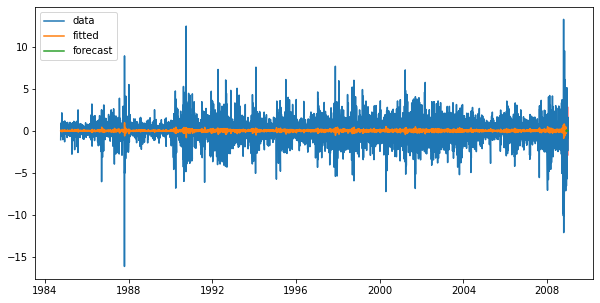

In [18]:
plot_result(model, df_ibovespa["rt"], X_train['rt'], X_test['rt'])

In [19]:
def plot_test(model, test):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test.index, test, label='true')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[0:,1], color='red', alpha=0.3)
    ax.legend();

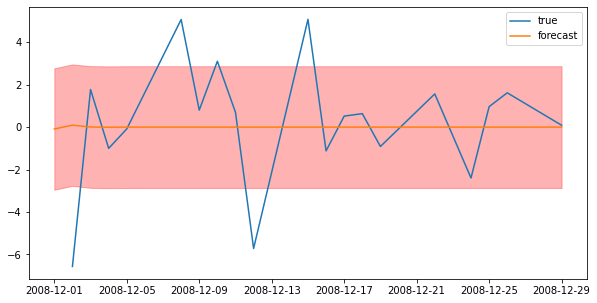

In [20]:
plot_test(model, X_test['rt'])

In [21]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [22]:
predictions = model.predict(Ntest)
# predictions2 = predictions.reshape(Ntest,1)

In [23]:
# predictions2= predictions2.reshape(1,-1)[0]

In [24]:
a = rmse(predictions, X_test["rt"])

In [27]:
#print("RSME ARIMA:", round(rmse(predictions, X_test["rt"]), 4))
print(f"RSME ARIMA: {round(a, 4)}%")
print("RSME Naive:", rmse(X_train['rt'].iloc[-1], X_test['rt']))

RSME ARIMA: 2.8818%
RSME Naive: 3.267815535960453


In [59]:
predictions

array([-8.95987906e-02,  9.23164587e-02,  4.60779867e-03, -6.24074642e-03,
       -2.14607671e-04,  4.20434152e-04,  8.05223090e-06, -2.82284027e-05,
       -1.15658683e-07,  1.88892218e-06, -2.05508041e-08, -1.25974881e-07,
        3.26014867e-09,  8.37314923e-09, -3.43327282e-10, -5.54640437e-10,
        3.12576146e-11,  3.66120798e-11, -2.63790388e-12, -2.40817768e-12])

In [60]:
X_test['rt_predict'] = predictions
X_test.fillna(value=0, inplace=True)
X_test = X_test.round(3)

X_test

,Open,High,Low,Close,Adj Close,Volume,rt,rt_predict
Date,,,,,,,,
2008-12-01,8464.36,8464.36,8307.28,8397.22,8397.22,106900000,0.000,-0.090
2008-12-02,8266.32,8266.32,7863.69,7863.69,7863.69,136000000,-6.564,0.092
2008-12-03,7965.31,8056.38,7889.82,8004.10,8004.10,121200000,1.770,0.005
2008-12-04,8030.20,8107.69,7849.84,7924.24,7924.24,147900000,-1.003,-0.006
2008-12-05,7975.05,8024.33,7908.65,7917.51,7917.51,139400000,-0.085,-0.000
2008-12-08,7970.69,8358.27,7959.01,8329.05,8329.05,138900000,5.067,0.000
2008-12-09,8362.37,8499.60,8314.85,8395.87,8395.87,150800000,0.799,0.000
2008-12-10,8376.00,8704.92,8376.00,8660.24,8660.24,155700000,3.100,-0.000
2008-12-11,8642.26,8720.55,8519.11,8720.55,8720.55,162100000,0.694,-0.000


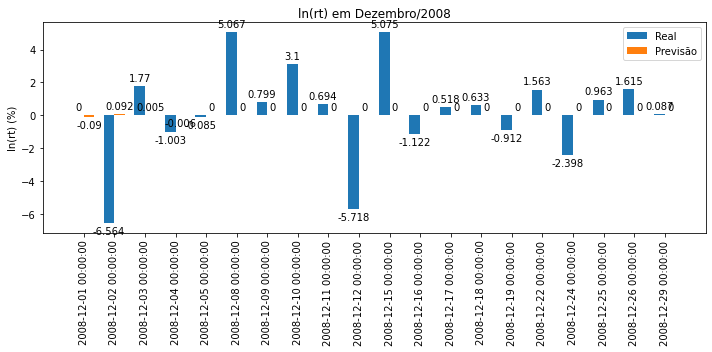

In [62]:

x = np.arange(len(X_test))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, X_test['rt'], width, label='Real')
rects2 = ax.bar(x + width/2, X_test['rt_predict'], width, label='Previsão')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ln(rt) (%)')
ax.set_title('ln(rt) em Dezembro/2008')
ax.set_xticks(x)
ax.set_xticklabels(X_test.index)
plt.xticks(rotation=90)

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()